README: This notebook is intendend to be run in the top level of a folder that contains the folder "audio" and "annotation". In the process of executing this notebook the folders "preprocessed_audio_not_normalized" and "preprocessed_audio" and "datasets" will be created. The datasets created during execution will be saved in "datasets" and the resulting main dataset "df_main" will be saved in the top level.

# 1. Import data

In [3]:
""" Import script for IDMT-Traffic dataset
Ref:
    J. Abeßer, S. Gourishetti, A. Kátai, T. Clauß, P. Sharma, J. Liebetrau: IDMT-Traffic: An Open Benchmark
    Dataset for Acoustic Traffic Monitoring Research, EUSIPCO, 2021
"""

import os
import glob
import pandas as pd

__author__ = 'Jakob Abeßer (jakob.abesser@idmt.fraunhofer.de)'


def import_idmt_traffic_dataset(fn_txt: str = "idmt_traffic_all") -> pd.DataFrame:
    """ Import IDMT-Traffic dataset
    Args:
        fn_txt (str): Text file with all WAV files
    Returns:
        df_dataset (pd.Dataframe): File-wise metadata
            Columns:
                'file': WAV filename,
                'is_background': True if recording contains background noise (no vehicle), False else
                'date_time': Recording time (YYYY-MM-DD-HH-mm)
                'location': Recording location
                'speed_kmh': Speed limit at recording site (km/h), UNK if unknown,
                'sample_pos': Sample position (centered) within the original audio recording,
                'daytime': M(orning) or (A)fternoon,
                'weather': (D)ry or (W)et road condition,
                'vehicle': (B)us, (C)ar, (M)otorcycle, or (T)ruck,
                'source_direction': Source direction of passing vehicle: from (L)eft or from (R)ight,
                'microphone': (SE)= (high-quality) sE8 microphones, (ME) = (low-quality) MEMS microphones (ICS-43434),
                'channel': Original stereo pair channel (12) or (34)
    """
    # load file list
    df_files = pd.read_csv(fn_txt, names=('file',))
    fn_file_list = df_files['file'].to_list()

    # load metadata from file names
    df_dataset = []

    for f, fn in enumerate(fn_file_list):
        fn = fn.replace('.wav', '')
        parts = fn.split('_')

        # background noise files
        if '-BG' in fn:
            date_time, location, speed_kmh, sample_pos, mic, channel = parts
            vehicle, source_direction, weather, daytime = 'None', 'None', 'None', 'None'
            is_background = True

        # files with vehicle passings
        else:
            date_time, location, speed_kmh, sample_pos, daytime, weather, vehicle_direction, mic, channel = parts
            vehicle, source_direction = vehicle_direction
            is_background = False

        channel = channel.replace('-BG', '')
        speed_kmh = speed_kmh.replace('unknownKmh', 'UNK')
        speed_kmh = speed_kmh.replace('Kmh', '')

        df_dataset.append({'file': fn,
                           'is_background': is_background,
                           'date_time': date_time,
                           'location': location,
                           'speed_kmh': speed_kmh,
                           'sample_pos': sample_pos,
                           'daytime': daytime,
                           'weather': weather,
                           'vehicle': vehicle,
                           'source_direction': source_direction,
                           'microphone': mic,
                           'channel': channel})

    df_dataset = pd.DataFrame(df_dataset, columns=('file', 'is_background', 'date_time', 'location', 'speed_kmh', 'sample_pos', 'daytime', 'weather', 'vehicle',
                                                   'source_direction', 'microphone', 'channel'))

    return df_dataset


# if __name__ == '__main__':

    # example use
    # fn_txt_list = ["idmt_traffic_all.txt",    # complete IDMT-Traffic dataset
                   # "eusipco_2021_train.txt",  # training set of EUSIPCO 2021 paper
                   # "eusipco_2021_test.txt"]   # test set of EUSIPCO 2021 paper

    # import metadata
    # for fn_txt in fn_txt_list:
       #  print('Metadata for {}:'.format(fn_txt))
       #  print(import_idmt_traffic_dataset(fn_txt))

In [4]:
import os

# Define output directory for datasets
output_directory = "datasets"

# Ensure the datasets directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Directory '{output_directory}' created successfully!")
else:
    print(f"Directory '{output_directory}' already exists.")

# Save df_dataset to CSV
df_dataset = import_idmt_traffic_dataset("annotation/idmt_traffic_all.txt")
df_dataset.to_csv(os.path.join(output_directory, 'df_dataset.csv'), index=True)

Directory 'datasets' created successfully!


# 2. Add MFCC-Coefficients

## a) Preprocess Audio Files (with normalization). Folder: preprocessed_audio_not_normalized

In [5]:
import os
import numpy as np
from scipy.io import wavfile

def preprocess_audio_scipy(file_path, output_directory, target_sample_rate=22000, target_duration=2.0):
    """
    Preprocess audio using SciPy: convert to mono, downsample, trim/pad to 2 seconds, and normalize.
    Args:
        file_path (str): Path to the input audio file.
        output_directory (str): Directory to save the preprocessed file.
        target_sample_rate (int): Desired sampling rate for the audio.
        target_duration (float): Target duration in seconds.
    """
    # Load the audio file
    sample_rate, data = wavfile.read(file_path)

    # Convert to mono if stereo
    if len(data.shape) == 2:
        data = np.mean(data, axis=1).astype(data.dtype)

    # Downsample to the target sample rate
    if sample_rate != target_sample_rate:
        num_samples = int(len(data) * target_sample_rate / sample_rate)
        data = np.interp(
            np.linspace(0, len(data), num_samples, endpoint=False),
            np.arange(len(data)),
            data
        )
        sample_rate = target_sample_rate

    # Trim or pad the audio to the target duration
    target_length = int(sample_rate * target_duration)
    if len(data) > target_length:
        data = data[:target_length]
    elif len(data) < target_length:
        data = np.pad(data, (0, target_length - len(data)), mode='constant')

    # Normalize to zero mean and unit variance
    mean = np.mean(data)
    std = np.std(data)
    if std > 0:
        data = (data - mean) / std

    # Save the preprocessed file
    os.makedirs(output_directory, exist_ok=True)
    output_file = os.path.join(output_directory, os.path.basename(file_path))
    wavfile.write(output_file, sample_rate, data.astype(np.float32))
    print(f"Saved preprocessed file to: {output_file}")

def process_dataset_scipy(input_directory, output_directory):
    """
    Process all audio files in a directory using SciPy.
    Args:
        input_directory (str): Directory containing the original audio files.
        output_directory (str): Directory to save preprocessed files.
    """
    for file_name in os.listdir(input_directory):
        if file_name.endswith(".wav"):
            file_path = os.path.join(input_directory, file_name)
            preprocess_audio_scipy(file_path, output_directory)

In [6]:
import os

# Define input and output directories
input_directory = "audio"
output_directory = "preprocessed_audio"

# Ensure the output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Directory '{output_directory}' created successfully!")
else:
    print(f"Directory '{output_directory}' already exists.")

# Process the dataset
process_dataset_scipy(input_directory, output_directory)

Directory 'preprocessed_audio' created successfully!
Saved preprocessed file to: preprocessed_audio/2019-11-18-07-25_Langewiesener-Strasse_50Kmh_1103360_ME_CH12-BG.wav
Saved preprocessed file to: preprocessed_audio/2019-11-19-07-25_Langewiesener-Strasse_50Kmh_1033448_M_D_CR_SE_CH34.wav
Saved preprocessed file to: preprocessed_audio/2019-10-22-15-30_Fraunhofer-IDMT_30Kmh_9062400_ME_CH12-BG.wav
Saved preprocessed file to: preprocessed_audio/2019-11-19-15-25_Langewiesener-Strasse_50Kmh_3036482_A_D_CR_SE_CH34.wav
Saved preprocessed file to: preprocessed_audio/2019-11-12-09-00_Schleusinger-Allee_70Kmh_30814719_ME_CH12-BG.wav
Saved preprocessed file to: preprocessed_audio/2019-11-19-16-30_Langewiesener-Strasse_50Kmh_586040_A_D_CR_ME_CH12.wav
Saved preprocessed file to: preprocessed_audio/2019-11-13-08-00_Schleusinger-Allee_70Kmh_17972736_ME_CH12-BG.wav
Saved preprocessed file to: preprocessed_audio/2019-11-19-07-25_Langewiesener-Strasse_50Kmh_1329128_M_D_CR_SE_CH34.wav
Saved preprocessed fil

## b) Calculate MFCC Coefficients

In [7]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.fftpack import dct

def calculate_mfcc_scipy(file_path, n_mfcc=13, n_mels=40, target_sample_rate=22000, fft_size=2048, hop_size=512):
    """
    Berechnet die MFCCs eines WAV-Files und gibt die Durchschnittswerte zurück.
    Args:
        file_path (str): Pfad zur Audio-Datei.
        n_mfcc (int): Anzahl der MFCC-Koeffizienten.
        n_mels (int): Anzahl der Mel-Bänder.
        target_sample_rate (int): Ziel-Abtastrate.
        fft_size (int): Größe des FFT-Fensters.
        hop_size (int): Schrittgröße zwischen den FFT-Fenstern.
    Returns:
        list: Durchschnittswerte der MFCCs.
    """
    # Lade das Audiofile
    sample_rate, data = wavfile.read(file_path)
    
    # Resampling prüfen
    if sample_rate != target_sample_rate:
        raise ValueError(f"Unexpected sample rate {sample_rate}. Expected {target_sample_rate}.")
    
    # Mono prüfen
    if len(data.shape) == 2:
        data = np.mean(data, axis=1)
    
    # Frame-Wise FFT
    frames = np.array([
        data[i:i+fft_size] * np.hamming(fft_size)
        for i in range(0, len(data) - fft_size, hop_size)
    ])
    magnitude = np.abs(np.fft.rfft(frames, axis=1))

    # Frequenzachse
    frequencies = np.fft.rfftfreq(fft_size, d=1/sample_rate)
    
    # Mel-Filterbank erstellen
    mel_filterbank = mel_filter_banks(sample_rate, fft_size, n_mels, frequencies)
    mel_power = np.dot(magnitude**2, mel_filterbank.T)

    # Logarithmische Skalierung
    log_mel = np.log(mel_power + 1e-10)

    # Diskrete Kosinustransformation (DCT) zur Reduktion
    mfccs = dct(log_mel, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    # Durchschnittswerte der MFCCs berechnen
    mean_mfccs = np.mean(mfccs, axis=0)
    return mean_mfccs

def mel_filter_banks(sample_rate, fft_size, n_mels, frequencies):
    """
    Erstellt ein Mel-Filterbank.
    """
    min_hz = 0
    max_hz = sample_rate // 2
    mel_min = 2595 * np.log10(1 + min_hz / 700)
    mel_max = 2595 * np.log10(1 + max_hz / 700)
    mel_points = np.linspace(mel_min, mel_max, n_mels + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    
    # Frequenz-Bins für die Filterbank
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)

    # Mel-Filterbank
    filterbank = np.zeros((n_mels, len(frequencies)))
    for i in range(1, n_mels + 1):
        start, center, end = bin_points[i - 1], bin_points[i], bin_points[i + 1]
        filterbank[i - 1, start:center] = (frequencies[start:center] - frequencies[start]) / (frequencies[center] - frequencies[start])
        filterbank[i - 1, center:end] = (frequencies[end] - frequencies[center:end]) / (frequencies[end] - frequencies[center])
    return filterbank

def process_audio_directory_scipy(input_directory, output_file, n_mfcc=13):
    """
    Berechnet MFCC-Durchschnittswerte für alle WAV-Dateien in einem Verzeichnis und speichert sie in einer Excel-Datei.
    Args:
        input_directory (str): Verzeichnis mit den Audio-Dateien.
        output_file (str): Pfad zur Ausgabedatei (Excel).
        n_mfcc (int): Anzahl der MFCC-Koeffizienten.
    """
    results = []
    for file_name in os.listdir(input_directory):
        if file_name.endswith(".wav"):
            file_path = os.path.join(input_directory, file_name)
            try:
                mfcc_means = calculate_mfcc_scipy(file_path, n_mfcc=n_mfcc)
                results.append({
                    'file': os.path.basename(file_path).replace('.wav', ''),  # Entfernt die .wav Endung
                    **{f'mfcc_{i+1}': value for i, value in enumerate(mfcc_means)}
                })
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    
    # Save to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)
    print(f"MFCC-Features saved to: {output_file}")

In [8]:
# Beispiel: Berechnung für ein Verzeichnis
input_directory = "preprocessed_audio"  # Pfad zu den WAV-Dateien
output_file = "datasets/mfcc_features.csv"
process_audio_directory_scipy(input_directory, output_file)

MFCC-Features saved to: datasets/mfcc_features.csv


# 3. Add Octave Bands

## a) Preprocess Audio files (without normalization). Folder: preprocessed_audio

In [9]:
import os
import numpy as np
from scipy.io import wavfile

def preprocess_audio_scipy(file_path, output_directory, target_sample_rate=22000, target_duration=2.0):
    """
    Preprocess audio using SciPy: convert to mono, downsample, trim/pad to 2 seconds, and normalize.
    Args:
        file_path (str): Path to the input audio file.
        output_directory (str): Directory to save the preprocessed file.
        target_sample_rate (int): Desired sampling rate for the audio.
        target_duration (float): Target duration in seconds.
    """
    # Load the audio file
    sample_rate, data = wavfile.read(file_path)

    # Convert to mono if stereo
    if len(data.shape) == 2:
        data = np.mean(data, axis=1).astype(data.dtype)

    # Downsample to the target sample rate
    if sample_rate != target_sample_rate:
        num_samples = int(len(data) * target_sample_rate / sample_rate)
        data = np.interp(
            np.linspace(0, len(data), num_samples, endpoint=False),
            np.arange(len(data)),
            data
        )
        sample_rate = target_sample_rate

    # Trim or pad the audio to the target duration
    target_length = int(sample_rate * target_duration)
    if len(data) > target_length:
        data = data[:target_length]
    elif len(data) < target_length:
        data = np.pad(data, (0, target_length - len(data)), mode='constant')

    # Save the preprocessed file
    os.makedirs(output_directory, exist_ok=True)
    output_file = os.path.join(output_directory, os.path.basename(file_path))
    wavfile.write(output_file, sample_rate, data.astype(np.float32))
    print(f"Saved preprocessed file to: {output_file}")

def process_dataset_scipy(input_directory, output_directory):
    """
    Process all audio files in a directory using SciPy.
    Args:
        input_directory (str): Directory containing the original audio files.
        output_directory (str): Directory to save preprocessed files.
    """
    for file_name in os.listdir(input_directory):
        if file_name.endswith(".wav"):
            file_path = os.path.join(input_directory, file_name)
            preprocess_audio_scipy(file_path, output_directory)

In [10]:
import os

# Define input and output directories
input_directory = "audio"
output_directory = "preprocessed_audio_not_normalized"

# Ensure the output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Directory '{output_directory}' created successfully!")
else:
    print(f"Directory '{output_directory}' already exists.")

# Process the dataset
process_dataset_scipy(input_directory, output_directory)

Directory 'preprocessed_audio_not_normalized' created successfully!
Saved preprocessed file to: preprocessed_audio_not_normalized/2019-11-18-07-25_Langewiesener-Strasse_50Kmh_1103360_ME_CH12-BG.wav
Saved preprocessed file to: preprocessed_audio_not_normalized/2019-11-19-07-25_Langewiesener-Strasse_50Kmh_1033448_M_D_CR_SE_CH34.wav
Saved preprocessed file to: preprocessed_audio_not_normalized/2019-10-22-15-30_Fraunhofer-IDMT_30Kmh_9062400_ME_CH12-BG.wav
Saved preprocessed file to: preprocessed_audio_not_normalized/2019-11-19-15-25_Langewiesener-Strasse_50Kmh_3036482_A_D_CR_SE_CH34.wav
Saved preprocessed file to: preprocessed_audio_not_normalized/2019-11-12-09-00_Schleusinger-Allee_70Kmh_30814719_ME_CH12-BG.wav
Saved preprocessed file to: preprocessed_audio_not_normalized/2019-11-19-16-30_Langewiesener-Strasse_50Kmh_586040_A_D_CR_ME_CH12.wav
Saved preprocessed file to: preprocessed_audio_not_normalized/2019-11-13-08-00_Schleusinger-Allee_70Kmh_17972736_ME_CH12-BG.wav
Saved preprocessed fi

## b) Octave Band Filter Function

In [11]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Public methods
__all__ = ['octavefilter', 'getansifrequencies', 'normalizedfreq']


def octavefilter(input_directory, fraction=1, order=6, limits=None, show=0, sigbands =0):
    """
    Filter a signal with octave or fractional octave filter bank. This
    method uses a Butterworth filter with Second-Order Sections
    coefficients. To obtain the correct coefficients, a subsampling is
    applied to the signal in each filtered band.

    :param x: Signal
    :param fs: Sample rate
    :param fraction: Bandwidth 'b'. Examples: 1/3-octave b=3, 1-octave b=1,
    2/3-octave b = 3/2. [Optional] Default: 1.
    :param order: Order of Butterworth filter. [Optional] Default: 6.
    :param limits: Minimum and maximum limit frequencies. [Optional] Default
    [12,20000]
    :param show: Boolean for plot o not the filter response.
    :param sigbands: Boolean to also return the signal in the time domain
    divided into bands. A list with as many arrays as there are frequency bands.
    :returns: Sound Pressure Level and Frequency array
    """

    if limits is None:
        limits = [12, 20000]

    fs, x = wavfile.read(input_directory)

    # mono transformation
    if len(x.shape) == 2:
        x = np.mean(x, axis=1)

    # Downsampling
    if fs != 22000:
        downsample_factor = np.round(fs / 22000)
        x = x[::int(downsample_factor)]
        fs = 22000
   
    # List type for signal var
    x = _typesignal(x)
    
    # Generate frequency array
    freq, freq_d, freq_u = _genfreqs(limits, fraction, fs)

    # Calculate the downsampling factor (array of integers with size [freq])
    factor = _downsamplingfactor(freq_u, fs)

    # Get SOS filter coefficients (3D - matrix with size: [freq,order,6])
    sos = _buttersosfilter(freq, freq_d, freq_u, fs, order, factor, show)

    if sigbands:
        # Create array with SPL for each frequency band
        spl = np.zeros([len(freq)])
        xb = []
        for idx in range(len(freq)):
            sd = signal.resample(x, round(len(x) / factor[idx]))
            y = signal.sosfilt(sos[idx], sd)
            spl[idx] = 20 * np.log10(np.std(y) / 2e-5)
            xb.append(signal.resample_poly(y,factor[idx],1))
        return spl.tolist(), freq, xb
    else:
        # Create array with SPL for each frequency band
        spl = np.zeros([len(freq)])
        for idx in range(len(freq)):
            sd = signal.resample(x, round(len(x) / factor[idx]))
            y = signal.sosfilt(sos[idx], sd)
            spl[idx] = 20 * np.log10(np.std(y) / 2e-5)
        return spl.tolist(), freq


def _typesignal(x):
    if type(x) is list:
        return x
    elif type(x) is np.ndarray:
        return x.tolist()
    elif type(x) is tuple:
        return list(x)


def _buttersosfilter(freq, freq_d, freq_u, fs, order, factor, show=0):
    # Initialize coefficients matrix
    sos = [[[]] for i in range(len(freq))]
    # Generate coefficients for each frequency band
    for idx, (lower, upper) in enumerate(zip(freq_d, freq_u)):
        # Downsampling to improve filter coefficients
        fsd = fs / factor[idx]  # New sampling rate
        # Butterworth Filter with SOS coefficients
        sos[idx] = signal.butter(
            N=order,
            Wn=np.array([lower, upper]) / (fsd / 2),
            btype='bandpass',
            analog=False,
            output='sos')

    if show:
        _showfilter(sos, freq, freq_u, freq_d, fs, factor)

    return sos


def _showfilter(sos, freq, freq_u, freq_d, fs, factor):
    wn = 8192
    w = np.zeros([wn, len(freq)])
    h = np.zeros([wn, len(freq)], dtype=np.complex128)

    for idx in range(len(freq)):
        fsd = fs / factor[idx]  # New sampling rate
        w[:, idx], h[:, idx] = signal.sosfreqz(
            sos[idx],
            worN=wn,
            whole=False,
            fs=fsd)

    fig, ax = plt.subplots()
    ax.semilogx(w, 20 * np.log10(abs(h) + np.finfo(float).eps), 'b')
    ax.grid(which='major')
    ax.grid(which='minor', linestyle=':')
    ax.set_xlabel(r'Frequency [Hz]')
    ax.set_ylabel('Amplitude [dB]')
    ax.set_title('Second-Order Sections - Butterworth Filter')
    plt.xlim(freq_d[0] * 0.8, freq_u[-1] * 1.2)
    plt.ylim(-4, 1)
    ax.set_xticks([16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
    ax.set_xticklabels(['16', '31.5', '63', '125', '250', '500',
                        '1k', '2k', '4k', '8k', '16k'])
    plt.show()


def _genfreqs(limits, fraction, fs):
    # Generate frequencies
    freq, freq_d, freq_u = getansifrequencies(fraction, limits)

    # Remove outer frequency to prevent filter error (fs/2 < freq)
    freq, freq_d, freq_u = _deleteouters(freq, freq_d, freq_u, fs)

    return freq, freq_d, freq_u


def normalizedfreq(fraction):
    """
    Normalized frequencies for one-octave and third-octave band. [IEC
    61260-1-2014]

    :param fraction: Octave type, for one octave fraction=1,
    for third-octave fraction=3
    :type fraction: int
    :returns: frequencies array
    :rtype: list
    """
    predefined = {1: _oneoctave(),
                  3: _thirdoctave(),
                  }
    return predefined[fraction]


def _thirdoctave():
    # IEC 61260 - 1 - 2014 (added 12.5, 16, 20 Hz)
    return [12.5, 16, 20, 25, 31.5, 40, 50, 63, 80, 100, 125, 160, 200, 250,
            315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150, 4000,
            5000, 6300, 8000, 10000, 12500, 16000, 20000]


def _oneoctave():
    # IEC 61260 - 1 - 2014 (added 16 Hz)
    return [16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]


def _deleteouters(freq, freq_d, freq_u, fs):
    idx = np.asarray(np.where(np.array(freq_u) > fs / 2))
    if any(idx[0]):
        _printwarn('Low sampling rate, frequencies above fs/2 will be removed')
        freq = np.delete(freq, idx).tolist()
        freq_d = np.delete(freq_d, idx).tolist()
        freq_u = np.delete(freq_u, idx).tolist()
    return freq, freq_d, freq_u


def getansifrequencies(fraction, limits=None):
    """ ANSI s1.11-2004 && IEC 61260-1-2014
    Array of frequencies and its edges according to the ANSI and IEC standard.

    :param fraction: Bandwidth 'b'. Examples: 1/3-octave b=3, 1-octave b=1,
    2/3-octave b = 3/2
    :param limits: It is a list with the minimum and maximum frequency that
    the array should have. Example: [12,20000]
    :returns: Frequency array, lower edge array and upper edge array
    :rtype: list, list, list
    """

    if limits is None:
        limits = [12, 20000]

    # Octave ratio g (ANSI s1.11, 3.2, pg. 2)
    g = 10 ** (3 / 10)  # Or g = 2
    # Reference frequency (ANSI s1.11, 3.4, pg. 2)
    fr = 1000

    # Get starting index 'x' and first center frequency
    x = _initindex(limits[0], fr, g, fraction)
    freq = _ratio(g, x, fraction) * fr

    # Get each frequency until reach maximum frequency
    freq_x = 0
    while freq_x * _bandedge(g, fraction) < limits[1]:
        # Increase index
        x = x + 1
        # New frequency
        freq_x = _ratio(g, x, fraction) * fr
        # Store new frequency
        freq = np.append(freq, freq_x)

    # Get band-edges
    freq_d = freq / _bandedge(g, fraction)
    freq_u = freq * _bandedge(g, fraction)

    return freq.tolist(), freq_d.tolist(), freq_u.tolist()


def _initindex(f, fr, g, b):
    if b % 2:  # ODD ('x' solve from ANSI s1.11, eq. 3)
        return np.round(
                (b * np.log(f / fr) + 30 * np.log(g)) / np.log(g)
                )
    else:  # EVEN ('x' solve from ANSI s1.11, eq. 4)
        return np.round(
                (2 * b * np.log(f / fr) + 59 * np.log(g)) / (2 * np.log(g))
                )


def _ratio(g, x, b):
    if b % 2:  # ODD (ANSI s1.11, eq. 3)
        return g ** ((x - 30) / b)
    else:  # EVEN (ANSI s1.11, eq. 4)
        return g ** ((2 * x - 59) / (2 * b))


def _bandedge(g, b):
    # Band-edge ratio (ANSI s1.11, 3.7, pg. 3)
    return g ** (1 / (2 * b))


def _printwarn(msg):
    print('*********\n' + msg + '\n*********')


def _downsamplingfactor(freq, fs):
    guard = 0.10
    factor = (np.floor((fs / (2+guard)) / np.array(freq))).astype('int')
    for idx in range(len(factor)):
        # Factor between 1<factor<50
        factor[idx] = max(min(factor[idx], 50), 1)
    return factor

## c) Test the function on one file

*********
Low sampling rate, frequencies above fs/2 will be removed
*********


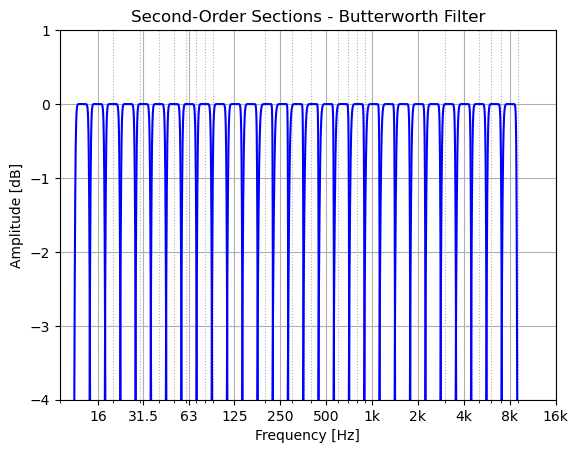

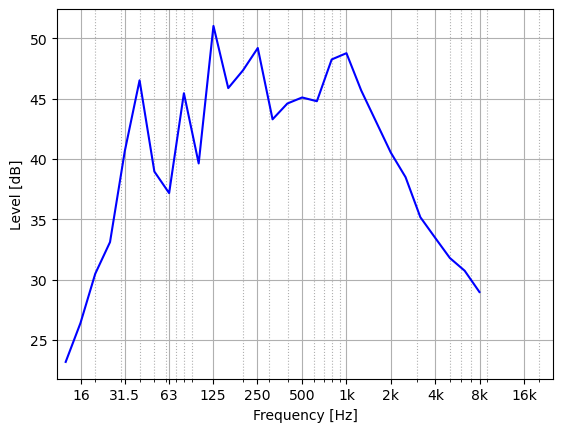

In [12]:
from scipy.io import wavfile
pathi = "audio/2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_41346_M_D_CR_SE_CH34.wav"

#sample_rate, data = wavfile.read(pathi)
spl, freq = octavefilter(pathi, fraction=3, order=6, limits=[12, 20000], show=1)

# Show octave spectrum
fig, ax = plt.subplots()
ax.semilogx(freq, spl, 'b')
ax.grid(which='major')
ax.grid(which='minor', linestyle=':')
ax.set_xlabel(r'Frequency [Hz]')
ax.set_ylabel('Level [dB]')
plt.xlim(11, 25000)
ax.set_xticks([16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
ax.set_xticklabels(['16', '31.5', '63', '125', '250', '500', '1k', '2k', '4k', '8k', '16k'])
plt.show()

## d) Apply to the whole dataset

In [13]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.fftpack import dct


def process_dataset_octaveband(input_directory, output_file, n, m):
    """
    Perform octave filter of (fraction n ) on all .wav files in a repository, 
    save all octave band SPL values and the (number of m) highest dB values 
    with their corresponding frequency band in an Excel file.
    
    Args:
        input_directory (str): Input repository.
        output_file (str): Path to output file (Excel).
        n (int): Fraction of octave band filters per octave.
        m (int): Number of dB peaks that should be saved from each file.
    """
    results = []
    
    for file_name in os.listdir(input_directory):
        if file_name.endswith(".wav"):
            file_path = os.path.join(input_directory, file_name)
            try:
                # Calculate SPL values and frequencies for all bands
                spl, freq = octavefilter(file_path, fraction=n, order=6, limits=[12, 20000], show=0)
                pairs = list(zip(spl, freq))
                pairs_sorted = sorted(pairs, key=lambda x: x[0], reverse=True)  # Sort by SPL
                
                # Get top m peaks
                top_pairs = pairs_sorted[:m]

                # Save all band values and top peaks
                result_entry = {
                    'file': os.path.basename(file_path).replace('.wav', '')
                }
                
                # Save all octave band values
                for i, (db, f) in enumerate(pairs):
                    result_entry[f'band_{i+1}_dB'] = db

                # Save top m peaks
                for i, (db, f) in enumerate(top_pairs):
                    result_entry[f'peak_dB_{i+1}'] = db
                    result_entry[f'peak_freq_{i+1}']= f
                
                # Save db bands average value
                result_entry['octband_dB_mean'] = sum(spl) / len(spl)

                results.append(result_entry)
    
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    
    # Save as new CSV file
    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)
    
    print(f"Octave-Band-Filter results with {m} peaks and fraction {n} saved in: {output_file}")

In [14]:
# Apply octave band filter with n = 1 and m = 3 on the total dataset
input_directory = "preprocessed_audio_not_normalized"  # Input directory
output_file = "datasets/spl_octaveband_results_30.csv"  # Output file
process_dataset_octaveband(input_directory, output_file, n=3, m=3)

*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be remo

/var/folders/vh/1t1ywg4n4fq7xwpclrv4jdyc0000gn/T/ipykernel_36304/3859306363.py:73: RuntimeWarning: divide by zero encountered in log10
  spl[idx] = 20 * np.log10(np.std(y) / 2e-5)


*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be removed
*********
*********
Low sampling rate, frequencies above fs/2 will be remo

# 4. Create df_main

In [16]:
df_dataset = pd.read_csv("datasets/df_dataset.csv")
mfcc_features = pd.read_csv("datasets/mfcc_features.csv")
spl_octaveband_results_30 = pd.read_csv("datasets/spl_octaveband_results_30.csv")

# Merge the datasets
df_merged = pd.merge(df_dataset, mfcc_features, on='file')
df_main = pd.merge(df_merged, spl_octaveband_results_30, on='file')

# Save the merged dataset
df_main.to_csv("datasets/df_main.csv", index=False)

TypeError: merge() got an unexpected keyword argument 'index'